In [49]:
using LinearAlgebra
using Optim
using Plots

# Custom factorial function for BigFloat
function factorial_big(x::BigFloat)
    if x == BigFloat(0)
        return BigFloat(1.0)
    else
        return x * factorial_big(x - BigFloat(1))
    end
end

# Set up the points with BigFloat
p1 = BigFloat[0.0, 0.0]
p2 = BigFloat[1.0, 0.0]
p3 = BigFloat[0.0, 1.0]
# p3 = BigFloat[0.5, sqrt(BigFloat(3))/2]


m1 = (p2 .+ p3) ./ BigFloat(2.0)
m2 = (p1 .+ p3) ./ BigFloat(2.0)
m3 = (p1 .+ p2) ./ BigFloat(2.0)

b = (p1 .+ p2 .+ p3) ./ BigFloat(3.0)

# vertices
T1 = hcat(p1, p2, p3)
eval_T1(i, j) = T1[1, :] .^ BigFloat(i) .* T1[2, :] .^ BigFloat(j)

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(i, j) = T2[1, :] .^ BigFloat(i) .* T2[2, :] .^ BigFloat(j)

# midpoint
T3 = hcat(b)
eval_T3(i, j) = T3[1, :] .^ BigFloat(i) .* T3[2, :] .^ BigFloat(j)

# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(a, i, j) = T4(a)[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* T4(a)[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))

dT4 = hcat(p1 .- p2, p2 .- p1, p3 .- p1, p1 .- p3, p3 .- p2, p2 .- p3)
eval_dT4(i, j) = dT4[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* dT4[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, a * m2 .+ (1 .- a) * p2, a * m3 .+ (1 .- a) * p3)
dT5 = hcat(m1 .- p1, m2 .- p2, m3 .- p3)
eval_T5(a, i, j) = T5(a)[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* T5(a)[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))

# Integral function using custom factorial_big
function integral(i, j)
    factorial_big(BigFloat(j)) * factorial_big(BigFloat(i)) / factorial_big(BigFloat(i + j + 2))
end

# System setup
function Aij(i, j, a)
    vcat(sum(eval_T1(i, j)),
         sum(eval_T4(a[1], i, j)), # edge class
         sum(eval_T5(a[2], i, j)),
         sum(eval_T5(a[3], i, j)))
end

A(a,order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)

# if the points p1,p2,p3 change then so must this integral
rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)

rhs (generic function with 1 method)

In [50]:
order = 6
# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order), 2)

f (generic function with 1 method)

BigFloat[0.299999999999999988897769753748434595763683319091796875, 0.2300000000000000099920072216264088638126850128173828125, 0.84999999999999997779553950749686919152736663818359375]

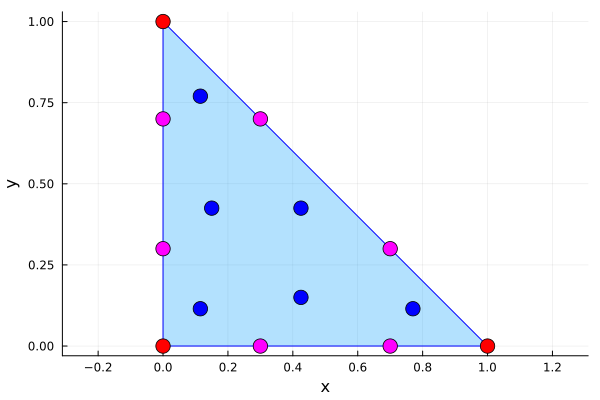

In [51]:
# Define the bounds
lower_bounds = BigFloat[0.0, 0.0, 0.0]
upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.0
max_val = 0.5
a = min_val .+ (max_val - min_val) .* BigFloat.(rand(3))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
a = BigFloat[0.3, 0.23, 0.85]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################
using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T1[1, :], T1[2, :], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)
scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 8, markercolor = :magenta, legend = false, aspect_ratio = :equal)
scatter!(T5(a[2])[1, :], T5(a[2])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
#########################################################################################################################

# Add plot title and labels
xlabel!("x")
ylabel!("y")

In [52]:
print(a)

using Optim, LineSearches

td = TwiceDifferentiable(f, a; autodiff = :forward);
result = optimize(td, a, Newton(;linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

print(result)
# stop

# # Set up the optimization problem with bounds
# # result = optimize(f, lower_bounds, upper_bounds, BigFloat[0.1, 0.1, 0.2], Fminbox(NelderMead()), Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = false))
# result = optimize(fad,
#             lower_bounds,
#             upper_bounds,
#             a,
#             Fminbox(GradientDescent()),
#             # Fminbox(NelderMead()),
#             # Fminbox(SimulatedAnnealing()),            
#             autodiff = :forward,
#             Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 100, time_limit = 1000))
            
a = Optim.minimizer(result)
f(a)

BigFloat[0.299999999999999988897769753748434595763683319091796875, 0.2300000000000000099920072216264088638126850128173828125, 0.84999999999999997779553950749686919152736663818359375]Iter     Function value   Gradient norm 
     0     2.974730e-05     4.524901e-03
 * time: 0.0
     1     3.352697e-06     4.110663e-03
 * time: 0.17600011825561523
     2     2.981959e-07     3.214809e-03
 * time: 0.2669999599456787
     3     4.150819e-09     5.931601e-04
 * time: 0.4230000972747803
     4     2.929661e-12     2.804161e-03
 * time: 0.6610000133514404
     5     1.001858e-18     2.846652e-03
 * time: 1.0929999351501465
     6     3.227143e-27     2.846438e-03
 * time: 1.7409999370574951
     7     3.227143e-27     2.846438e-03
 * time: 2.071000099182129
 * Status: success

 * Candidate solution
    Final objective value:     3.227143e-27

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.

3.227142990970465902114875516446533149179286976653776203196180917112509430863915e-27

In [53]:
f(a)
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))
a

3-element Vector{BigFloat}:
 0.307745941625991646104629685878131828193906809422248091623904150920995487539305
 0.2372273727931857363813289104703338597527845768596128178019239065707787007876839
 0.8506802519794943040508568765490842145556441642519058471819074502844651840385099

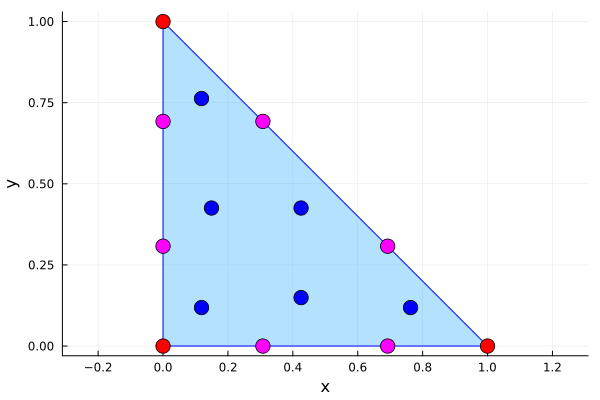

In [54]:
using Plots

x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

plot()

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T1[1, :], T1[2, :], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)
scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 8, markercolor = :magenta, legend = false, aspect_ratio = :equal)
scatter!(T5(a[2])[1, :], T5(a[2])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")